# Chapter 10: How to Use Iterative Imputation

##  What is Iterative Imputation?
**Iterative Imputation** is an advanced technique used to handle missing data in a dataset.  
Instead of simply filling missing values with a fixed statistic like mean or median, it **models each feature with missing values as a function of the other features**.

- This modeling is done in an **iterative (repeated)** manner.
- As missing values are imputed, they are used to impute others — making the estimates more refined over time.
- This technique is based on a statistical method known as **Multivariate Imputation by Chained Equations (MICE)** or **Fully Conditional Specification (FCS)**.

---

##  Why Use Iterative Imputation?
- Many machine learning algorithms **cannot work** with missing values (`NaN`).
- Simple imputation methods like mean/median do **not capture relationships** between variables.
- Iterative Imputation **uses all other features** to estimate a missing value for one feature, improving accuracy.
- Works well when the **multivariate distribution** of features is meaningful.

---

##  How It Works (Conceptually)
1. **Initialize** missing values with simple estimates (e.g., mean).
2. Choose one feature with missing values.
3. **Model this feature** using a regression model where all other features are predictors.
4. Use this model to **predict and replace** the missing values.
5. Move to the next feature and repeat the process.
6. Iterate the above steps **multiple times** (e.g., 10–20 times).
7. With each iteration, the imputed values become **more accurate** as they are based on updated estimates.

---

##  Dataset Used: Horse Colic Dataset
- A medical dataset describing characteristics of horses with colic.
- Target: Whether a surgery was needed (binary classification).
- Contains many missing values, marked as `"?"`, which are converted to `NaN`.
- Used to demonstrate how iterative imputation improves data quality before modeling.

---

##  Key Implementation Concepts
- The class `IterativeImputer` from `scikit-learn` is used.
- Default estimator: `BayesianRidge` regression.
- Features are filled in **ascending order** of missingness by default (from fewest to most missing).
- Experimental feature: Requires `enable_iterative_imputer` to use.

---

## Imputation Order
You can specify the **order in which features are imputed**, which can influence performance:
- `'ascending'`: Fewest missing values first (default).
- `'descending'`: Most missing values first.
- `'roman'`: Left-to-right.
- `'arabic'`: Right-to-left.
- `'random'`: Random order.

 **Observation**: Imputation order may have **slight impact**, and should be tested for your dataset.

---

##  Number of Iterations
- The imputation process is repeated for better estimates.
- Default: `max_iter=10`.
- Too few iterations may underfit; too many may lead to overfitting.
- Best number of iterations can vary — try values from **1 to 20**.

---

##  Model Evaluation with Iterative Imputation
- Always use imputation **inside a pipeline** to prevent **data leakage**.
- Data leakage happens when imputation is done **before cross-validation**, causing test data to influence training.
- Solution: Use `Pipeline` with:
  - Step 1: `IterativeImputer`
  - Step 2: Machine Learning Model (e.g., RandomForest)

 This ensures imputation is done **only on training data within each fold**.

---

##  Performance Insight
- Iterative Imputation usually performs **better than simple strategies**.
- Especially effective when there are **complex interactions** between features.
- Requires more time and computational power, but the **accuracy benefit can be significant**.

---

##  Final Prediction with New Data
- You can **fit a pipeline** on all available data and **predict on a new row** with missing values.
- The new row must contain `NaN` values to represent missing data.
- The pipeline will handle imputation and prediction together.

---

##  Summary of Key Points

- Iterative Imputation replaces missing values using **regression models** trained on other features.
- It is an **iterative process**, producing more refined estimates over time.
- Avoids data leakage by being used within **`Pipeline`** objects.
- Use **cross-validation** to test different imputation strategies and iterations.
- Can outperform basic imputation methods in **complex datasets**.
- Best suited for situations with many features and **non-linear relationships**.


In [4]:
from pandas import read_csv

# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')

# summarize the first few rows
print(dataframe.head())


# summarize the number of rows with missing values for each column
for i in range(dataframe.shape[1]):
    # count number of rows with missing values
    n_miss = dataframe[[i]].isnull().sum().iloc[0]
    perc = n_miss / dataframe.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

    0   1        2     3      4     5    6    7    8    9   ...    18    19  \
0  2.0   1   530101  38.5   66.0  28.0  3.0  3.0  NaN  2.0  ...  45.0   8.4   
1  1.0   1   534817  39.2   88.0  20.0  NaN  NaN  4.0  1.0  ...  50.0  85.0   
2  2.0   1   530334  38.3   40.0  24.0  1.0  1.0  3.0  1.0  ...  33.0   6.7   
3  1.0   9  5290409  39.1  164.0  84.0  4.0  1.0  6.0  2.0  ...  48.0   7.2   
4  2.0   1   530255  37.3  104.0  35.0  NaN  NaN  6.0  2.0  ...  74.0   7.4   

    20   21   22  23     24  25  26  27  
0  NaN  NaN  2.0   2  11300   0   0   2  
1  2.0  2.0  3.0   2   2208   0   0   2  
2  NaN  NaN  1.0   2      0   0   0   1  
3  3.0  5.3  2.0   1   2208   0   0   1  
4  NaN  NaN  2.0   2   4300   0   0   2  

[5 rows x 28 columns]
> 0, Missing: 1 (0.3%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 60 (20.0%)
> 4, Missing: 24 (8.0%)
> 5, Missing: 58 (19.3%)
> 6, Missing: 56 (18.7%)
> 7, Missing: 69 (23.0%)
> 8, Missing: 47 (15.7%)
> 9, Missing: 32 (10.7%)
> 10, M

#### 2 - Iterative Imputation With Iterative Imputer

##### 2.1 - Iterative Imputer Data Transform


In [11]:
# iterative imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

dataframe = read_csv('horse-colic.csv', header=None, na_values='?')

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

# summarize total missing
print('Missing: %d' % sum(isnan(X).flatten()))

# define imputer
imputer = IterativeImputer()

# fit on the dataset
imputer.fit(X)

# transform the dataset
Xtrans = imputer.transform(X)

# summarize total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 1605
Missing: 0


##### 2.2 - Iterative Imputer and Model Evaluation

In [26]:
# evaluate iterative imputation and random forest for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = IterativeImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy:', mean(scores)*100.00)

Mean Accuracy: 87.66666666666666


#### 2.3 - Iterative Imputer and Different Imputation Order

>ascending 86.889 
>descending 87.222 
>roman 87.444 
>arabic 86.889 
>random 87.556 


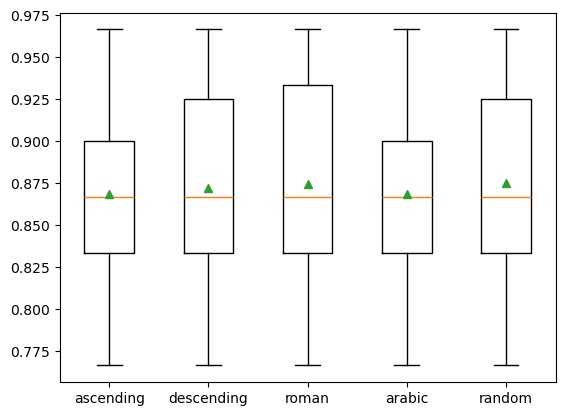

In [47]:
# compare iterative imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

dataframe = read_csv('horse-colic.csv', header=None, na_values='?')

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

# evaluate each strategy on the dataset
results = list()
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for s in strategies:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', IterativeImputer(imputation_order=s)), ('m',
    RandomForestClassifier())])
    
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    # store results
    results.append(scores)
    print('>%s %.3f ' % (s, mean(scores)*100))



# plot model performance for comparison
pyplot.boxplot(results, tick_labels=strategies, showmeans=True)
pyplot.show()

#### 2.4 - Iterative Imputer and Different Number of Iterations

>1 86.667 
>2 86.889 
>3 87.222 
>4 86.667 
>5 87.444 
>6 87.333 
>7 86.556 
>8 87.222 
>9 86.778 
>10 87.222 
>11 87.333 
>12 86.667 
>13 86.778 
>14 87.111 
>15 87.000 
>16 87.222 
>17 87.000 
>18 87.000 
>19 87.111 
>20 87.444 


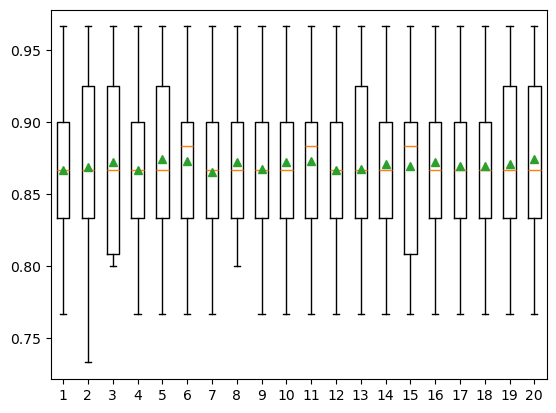

In [53]:
# compare iterative imputation number of iterations for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

dataframe = read_csv('horse-colic.csv', header=None, na_values='?')

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in range(1, 21)]
for s in strategies:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter=int(s))), ('m',
    RandomForestClassifier())])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # store results
    results.append(scores)
    print('>%s %.3f ' % (s, mean(scores)*100))



# plot model performance for comparison
pyplot.boxplot(results, tick_labels=strategies, showmeans=True)
pyplot.show()

#### 2.5 - Iterative Imputer Transform When Making a Prediction

In [58]:
# iterative imputation strategy and prediction for the horse colic dataset
from numpy import nan
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

dataframe = read_csv('horse-colic.csv', header=None, na_values='?')

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

# create the modeling pipeline
pipeline = Pipeline(steps=[('i', IterativeImputer()), ('m', RandomForestClassifier())])

# fit the model
pipeline.fit(X, y)

Pipeline(steps=[('i', IterativeImputer()), ('m', RandomForestClassifier())])

In [60]:
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00, 8.40, nan, nan, 2, 11300, 00000, 00000, 2]

# make a prediction
yhat = pipeline.predict([row])

# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


In [66]:
# define new data
row = [2, 1, 530101, 38.50, nan, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00, 8.40, nan, nan, 2, nan, nan, nan, nan]

# make a prediction
yhat = pipeline.predict([row])

# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


In [68]:
# define new data
row = [nan, 1, nan, 38.50, nan, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, nan, 45.00, 8.40, nan, nan, 2, 11300, nan, 00000, nan]

# make a prediction
yhat = pipeline.predict([row])

# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1
